# Introduction 
This project evaluates the impact of website background color on user engagement through A/B testing. Using data from a retail website in the United Kingdom, the data is segmented into two groups: Treatment group with a *new* black background and a control group with the default white background color. 

The primary goal is to determine whether changing the website background color from white to black significantly enhances engagemnet metrics such as the number of pages viewed, time spent on the website, and conversion rates. User engagement is crucial as it directly influences actions like purchases, registrations, and overall user satistfaction. 

The dataset contain user-specific information, including user ID, Group assignment (treated or not treated), page views, time spent (in seconds), conversion status, device type, and geographical location within the UK. By leveraging regression analysis and exploratory data analysis, the project aims to offer insights into user behaviour between the two website configurations, thereby assisting in data-driven decision-making for optimal website design. 

## Variable description
- **User ID:** User identifier
- **Group:** Contains both the control group (A) and treatment group (B)
- **Page Views:** The total amount of time, in seconds, that the user spent on the site during the session
- **Conversion:** Indicates whether a user has completed a desired action (Yes/No) 
- **Device:** Type of device used to access the website 
- **Location:** Place in the UK user is based in. 

In [102]:
# Importing libraries
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Global Figures
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('_classic_test_patch')

In [19]:
# Import the data, basic info and clean data 
data = pd.read_csv(r"C:\Users\sebas\OneDrive - BI Norwegian Business School (BIEDU)\GitHub\Portfolio\AB_testing\Data\ab_testing.csv")

# Some data info and generating a dummy for conversion
data["Conver_d"] = data["Conversion"].map({"Yes":1, "No":0})
data["treat"] = data["Group"].map({"B": 1, "A": 0})
data_info = data.info()
data_head = data.head()
data_desc = data.describe()
group_balance =data["Group"].value_counts()
data_info, data_head, data_desc, group_balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
 7   Conver_d    5000 non-null   int64 
 8   treat       5000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 351.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device     

(None,
    User ID Group  Page Views  Time Spent Conversion   Device          Location  Conver_d  treat
 0    14292     B           3         424         No   Mobile  Northern Ireland         0      1
 1    11682     A           9         342         No   Mobile          Scotland         0      0
 2    19825     A           2         396         No  Desktop  Northern Ireland         0      0
 3    16080     B           4         318         No  Desktop             Wales         0      1
 4    18851     A           1         338        Yes  Desktop          Scotland         1      0,
             User ID   Page Views   Time Spent     Conver_d        treat
 count   5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
 mean   14925.159000     7.537600   242.512600     0.097000     0.496200
 std     2869.153773     4.022465   118.254153     0.295987     0.500036
 min    10001.000000     1.000000    40.000000     0.000000     0.000000
 25%    12456.250000     4.000000   137.00000

**Some descriptive insights:**
- Average page views per user: ~ 7.54 pages/session 
- Average time spent per user: ~ 243 seconds (~ 4 minutes/session)
- Page views range from 1 to 14, and time spent ranges from
- ~ 9.7% of users have a positive conversion on the site
- 49.6 percent of individuals are in the treated sample.

# Group Comparision
We start the analysis by examining if there are any obvious group effects based on the treatment indicator using visualizations. The main outcomes we are interested in are:
- **Page views**
- **Time spent**
- **Conversion rate**

Text(0.5, 0, 'Group')

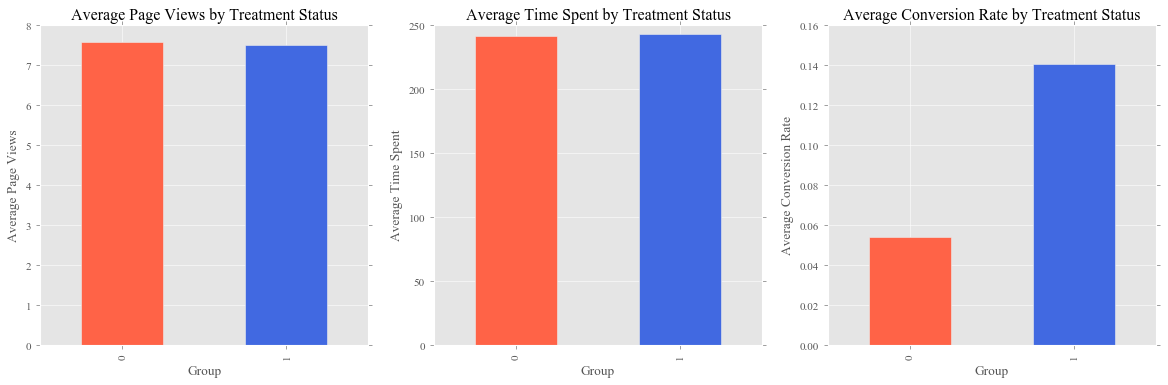

In [103]:
# Group wise averages
group_means = data.groupby("treat")[["Page Views", "Time Spent", "Conver_d"]].mean()
group_means

# Plot differences in mean
fig, axs = plt.subplots(1, 3, figsize=(18,5))

## Page views
group_means["Page Views"].plot(kind="bar", ax=axs[0], title="Average Page Views by Treatment Status", color=["tomato","royalblue"])
axs[0].set_ylabel("Average Page Views")
axs[0].set_xlabel("Group")

## Time spent
group_means["Time Spent"].plot(kind="bar", ax=axs[1], title="Average Time Spent by Treatment Status", color=["tomato","royalblue"])
axs[1].set_ylabel("Average Time Spent")
axs[1].set_xlabel("Group")

## Time spent
group_means["Conver_d"].plot(kind="bar", ax=axs[2], title="Average Conversion Rate by Treatment Status", color=["tomato","royalblue"])
axs[2].set_ylabel("Average Conversion Rate")
axs[2].set_xlabel("Group")

**Some insights:**
- *Page Views:*
    - Control group: ~ 7.58 pages per session
    - Treatment group: ~ 7.49 pages per session
- *Time Spent:*
    - Control group: ~ 241.7 seconds per session
    - Treatement group: ~ 243.3 seconds per session
- *Conversion rate:*
    - Control group: ~ 5.4 percent 
    - Treatment group: ~ 14.1 percent 

Hence, we only visually observe a difference in the conversion rate.


### Estimating the Treatment Effect
Given the insights above, we now turn to estimating the effect of the of changing the background color on the webpage. If treatment is perfectly randomdomized, there is no need to control for various factors in the regression. Let, $t_i$ be a treatment indicator for customer $i,$ then the effect of chaging the webpage color on outcome $y_i$ is given by
$$y_i=\alpha + \beta t_i+\epsilon,$$
where $y_i$ represents page views, time spent and the conversion rate, respectively.

#### Some (Nonsens) Checks Usually Done in A/B-Testing
Usually when individuals are doing A/B-testing, they check if (1) residuals are normally distributed; and (2) error variance is constant. Checking if the residuals are normally distributed have no impact on our analysis whatsoever. The assumption is on the population error term, not the residuals, hence it is not possible to check the assumption. What we can deduct, however, is that if the sample is large, $E(\epsilon_i\mid t_i)=0,$ and full rank, the error term will be asymptotically normal and hence standard $t$-tests will work for inference. For the error variance, non-constant variance can  yield inconsistent estimation of the standard errors, however, it is easily solved using heteroskedastic-robust standard errors. Lastly, under exogeneity and full rank, the parameter $\beta$ will be the causal effect of changing the color of the webpage. We cannot check if the exogeneity assumption holds, but under perfect random treatment assignment, it is reasonable to belive that it does. 



In [77]:
# Set up regression
outcomes = ["Page Views", "Time Spent", "Conver_d"]
results = {}

# Running regressions separately and storing results explicitly
outcomes = ["Page Views", "Time Spent", "Conver_d"]
regression_results = {}

for y in outcomes:
    X_y = sm.add_constant(data["treat"])
    model_y = sm.OLS(data[y], X_y).fit(cov_type="HC3")
    regression_results[y] = model_y

# Explicitly printing each regression summary separately to avoid truncation
for y, result in regression_results.items():
    print(f"\nRegression Summary for {y}:")
    print(result.summary())


Regression Summary for Page Views:
                            OLS Regression Results                            
Dep. Variable:             Page Views   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6068
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.436
Time:                        02:42:39   Log-Likelihood:                -14053.
No. Observations:                5000   AIC:                         2.811e+04
Df Residuals:                    4998   BIC:                         2.812e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7

#### Regression Results: Is there an Effect of Changing the Webpage Color?

1. **Page views:**
    - Treatment effect: $-0.0886$ (not statistically significant, $p=0.436$).
    - Interpretation: No significant difference in page views between control and treatment groups.
2. **Time spent:**
    - Treatment effect: $1.5707$ (not statistically significant, $p=0.639$)
    - Interpretation: No significant difference in time spent between control and treatment groups.
3. **Converstion rate:**
    - Treatment effect: $0.0867$ (significant, $p<0.001$)
    - Interpretation: Users exposed to the black background (treatment group) have an 8.67 percentage point higher probability of conversion compared to users with a white background.

Hence, we can conclude that changing the background color to black does not significantly increases time spent on the webpage or the number of pages that customers look at. However, it does increase the conversion rate. 

### Heterogeneity Analysis
Above we have estimated the effect for all devices and countries across the UK. Now we want to look if there is any heterogeneity across devices and countries. To do this, we run the regressions again, for each subset of data (device or country) to see if there are any differences across platforms or countries.

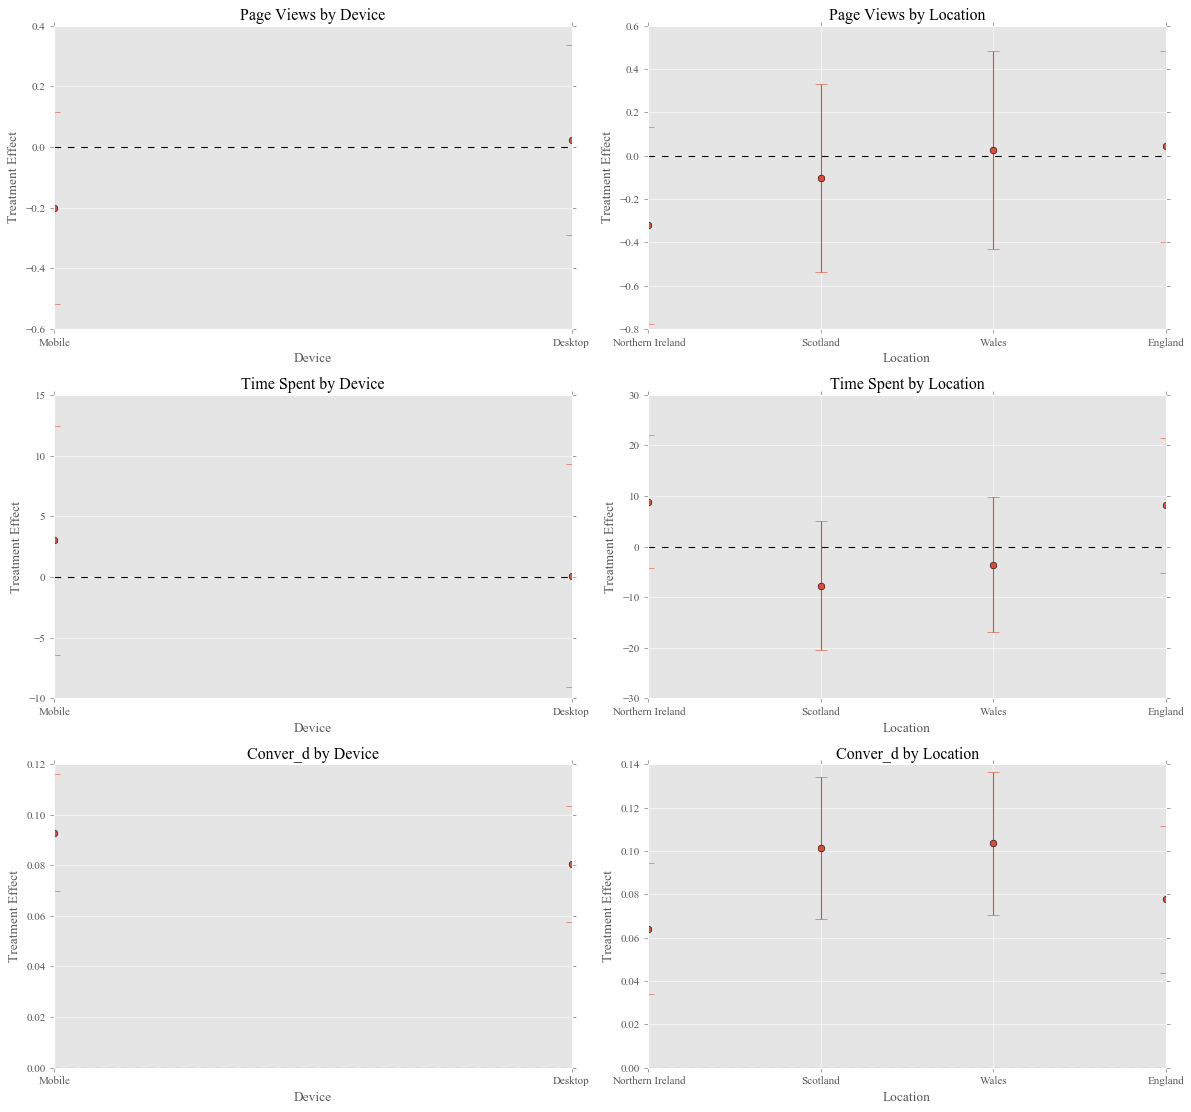

In [108]:
# Set up outcomes and subgroups which we want to compare
outcomes = ["Page Views", "Time Spent", "Conver_d"]
subgroups = ["Device", "Location"]
results = []

# Loop through subgroups and outcomes, ie. preform interacted regressions 
for subgroup in subgroups:
    categories = data[subgroup].unique()
    for category in categories:
        data_subset = data[data[subgroup] == category]
        for outcome in outcomes:
            x = sm.add_constant(data_subset["treat"])
            y = data_subset[outcome]
            model = sm.OLS(y,x).fit(cov_type="HC3")
            coef = model.params["treat"]
            conf_int = model.conf_int().loc["treat"]
            results.append({
                "Subgroup": subgroup,
                "Category": category,
                "Outcome": outcome,
                "Coefficient": coef,
                "CI Lower": conf_int[0],
                "CI Upper": conf_int[1]
            })

# Convert to DF for plotting
results_df = pd.DataFrame(results)

# Plotting point estimate + CI by subgroup
fig, axes = plt.subplots(3, 2, figsize=(15,14), sharey=False)

for i, outcome in enumerate(outcomes):
    for j, subgroup in enumerate(subgroups):
        ax = axes[i, j]
        plot_data = results_df[(results_df["Outcome"] == outcome) & (results_df["Subgroup"] == subgroup)]
        ax.errorbar(plot_data["Category"], plot_data["Coefficient"],
            yerr=[plot_data["Coefficient"] - plot_data["CI Lower"], plot_data["CI Upper"] - plot_data["Coefficient"]],
            fmt="o", capsize=5, linestyle="None")
        ax.axhline(0, color="black", linestyle="--")
        ax.set_title(f"{outcome} by {subgroup}")
        ax.set_ylabel("Treatment Effect")
        ax.set_xlabel(subgroup)

plt.tight_layout()
plt.show()

**Insights from figures:**
- There is no significant difference between countries or device type. Although we can see that the point estimates are a bit different, but not significantly.

# Conclusion
Across the entire sample, the black background shows highly significant positive impact on conversion rate, suggesting that users exposed to the black background are more likely to complete a desired action than those seeing the white backround. There are no statistically significant differences in page views nor time spent on the website, indicating that the website background color alone did not meaningfully shift how many pagers users brows or how long they stay on average. Consistent with the entire sample, the subgroup analysis shows the same results. Moreover, we do not find any statistically significant differences across devices nor locations. 

Hence, we have found that the black background strongly impacts conversion rates yet has a negligible influence on browsing intensity or session duration. Thus, from a marketing and product-design perspective, implementing the black background could boos conversions without diminishing the user's overall engagement - an appealing proposition. Overall, this A/B test suggests adopting the black background could meaningfully enhance user conversions without negatively affecting time or pages viewed. 